In [1]:
import scipy.io as sio

In [2]:
import os

In [3]:
mat_contents = sio.loadmat('/Users/hanany/Downloads/cam_DeepLearning/ImGHIrec2.mat')

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
path=os.getcwd()

In [5]:
DateTimeCom=sio.loadmat('/Users/hanany/Downloads/cam_DeepLearning/DateTimeCom.mat')
dt=DateTimeCom['DateTimeCom']


In [6]:
import numpy as np




In [7]:
import pandas as pd
dt=pd.to_datetime(dt)

In [8]:
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cam_Param', 'Coeffp', 'DB_Name', 'DHI', 'DHI_PSI', 'DNI', 'None', 'Day_ID', 'GHI', 'GHI_PSI', 'GPS', 'Gray64bits', 'HDR64bits', 'HDR_log64bits', 'ImGHIrec2', 'ImGreyghi', 'Image_ID', 'MAJ', 'Mask', 'N', 'PAA', 'PSA', 'PZA', 'RGB64bits', 'RSIFile', 'RSITemp', 'SAA', 'SPA', 'SPA_lim', 'SZA', 'Time_zone', 'Vout', 'dataPath', 'files', 'i', 'ind_PSI', 'ind_RSI', 'path_data', 'sqlquery', '__function_workspace__'])

In [9]:
mat_Im=mat_contents["ImGHIrec2"]
mat_Im.shape

(28, 26, 39502)

In [10]:
x=mat_Im[:,:,0]
y=mat_Im[:,:,5]

In [78]:
x=x.reshape(28*26,1)
y=y.reshape(28*26,1)


28*26

728

In [12]:

from matplotlib import pyplot as plt


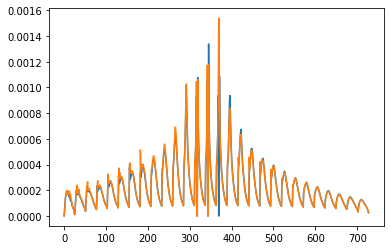

In [13]:
plt.plot(x)
plt.plot(y)
plt.show()

In [80]:

mat_Im.shape[0]*mat_Im.shape[1]

728

In [99]:
dataset_orig=mat_Im.reshape(mat_Im.shape[0]*mat_Im.shape[1],mat_Im.shape[2])

dataset_orig=dataset_orig[:,:13000]


#dataset_orig=dataset_orig[:,::4]




from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

#df_test['scaled_GHI'] = scaler.fit_transform(np.array(df_test['GHI']).reshape(-1, 1))

train_size=int(dataset_orig.shape[1]*.7)

data_train=dataset[:,:train_size]
data_test=dataset[:,train_size:]
data_train=data_train.T
data_test=data_test.T


In [100]:
data_train.shape,data_test.shape,dataset_orig.shape

#train_size

((9100, 728), (3900, 728), (728, 13000))

In [101]:
dimInput=1
X_train, y_train = data_train[:-1,:],data_train[dimInput:,:]
X_val, y_val = data_test[:-1,:],data_test[dimInput:,:]

In [103]:
X_val.shape,y_val.shape,X_train.shape,y_train.shape


((3899, 728), (3899, 728), (9099, 728), (9099, 728))

In [124]:
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

# %%
#definition des entrées. None indicates the number of instances
input_layer = Input(shape=(728,), dtype='float32')

# %%
#Les couches Denses avec une fonction d'activation relu
dense1 = Dense(32, activation='relu')(input_layer)
dropout_layer = Dropout(0.1)(dense1)
dense2 = Dense(128, activation='relu')(dense1)

dense3 = Dense(32, activation='relu')(dense2)
dropout_layer = Dropout(0.1)(dense3)

# dense4 = Dense(8, activation='relu')(dense3)
# dropout_layer = Dropout(0.1)(dense4)

# %%
output_layer = Dense(728, activation='relu')(dropout_layer)


# %%
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')

ts_model.summary()

# %%
save_weights_at = os.path.join(path, 'Cam_MLP_poids.{epoch:02d}-{val_loss:.4f}.hdf5')
print(save_weights_at)

# %%
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)


# %%
ts_model.fit(x=X_train, y=y_train, batch_size=100, epochs=10,verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
           shuffle=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 728)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 32)                23328     
_________________________________________________________________
dense_71 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_72 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_45 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 728)               24024     
Total params: 55,704
Trainable params: 55,704
Non-trainable params: 0
_________________________________________________________________
/Users

KeyboardInterrupt: 

In [120]:
files = sorted(os.listdir(path), key=os.path.getctime)

oldest = files[0]
newest = files[-1]
print(newest)

# %%
os.path.join(path,newest)

# %%
best_model = load_model(os.path.join(path,newest))
preds = best_model.predict(X_val)
pred_PRES = preds
pred_PRES = np.squeeze(pred_PRES)


from sklearn.metrics import r2_score,mean_squared_error
r2 = r2_score(y_val, pred_PRES)

#print('R-squared for the validation set:'.format(r2))
print("R-squared en test  est {} ".format(r2))

# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(y_val, pred_PRES))
print("L'erreur en test  est {} (nRMSE)".format(testScore))



Cam_MLP_poids.09-0.0025.hdf5
R-squared en test  est 0.9006537590465197 
L'erreur en test  est 0.04994149690664315 (nRMSE)


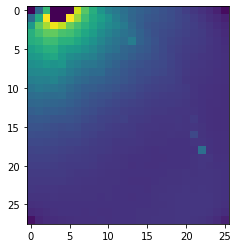

In [121]:

IM=y_val[59,:]
IM=IM.reshape(28, 26)

plt.imshow(IM)


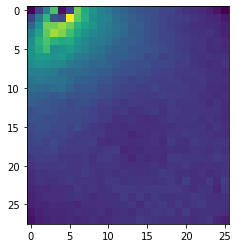

In [122]:
IM=pred_PRES[59,:]
IM=IM.reshape(28, 26)

plt.imshow(IM)



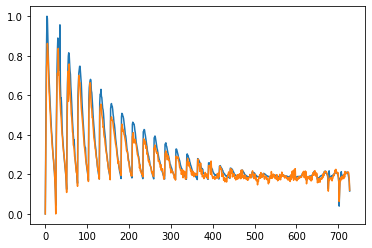

In [126]:
plt.plot(y_val[100,:])


plt.plot(pred_PRES[100,:])
plt.show()

In [3]:
# %%
import os 
# %%
import glob
path = os.getcwd()

file_list=glob.glob(path + "**/*.hdf5", recursive=True)
#print(file_list)
for f in file_list :
    os.remove(f)
#cprint("Tout les fichers hdf5 ont été supprimés !".center(50).upper(),'red')


# %%


12-Month Forecast With LSTM-Copy1.ipynb*
GHI_LSTM.ipynb*
GHI_MLP.ipynb*
GHI_MLP_Shab.ipynb*
GHI_MLP_Shab.py*
GPRforecasting.m*
GPRforecasting_Thil.asv*
GPRforecasting_Thil.m*
LSTM_conso.py*
LSTM_conso1.py*
LSTM_sim.py*
MLP_conso.py*
MLP_sim.ipynb*
MLP_sim.py*
Untitled.ipynb*
Untitled1.ipynb*
Untitled2.ipynb*
all_week.py*
cam_ghi.ipynb*
cam_ghi.py*
code_dl_Nouha 2/
data2016_30m.txt*
data2017_30m.txt*
data_Nouha.txt*
data_week_1.txt*
data_week_10.txt*
data_week_11.txt*
data_week_12.txt*
data_week_13.txt*
data_week_14.txt*
data_week_15.txt*
data_week_16.txt*
data_week_17.txt*
data_week_18.txt*
data_week_19.txt*
data_week_2.txt*
data_week_20.txt*
data_week_21.txt*
data_week_22.txt*
data_week_23.txt*
data_week_24.txt*
data_week_25.txt*
data_week_26.txt*
data_week_27.txt*
data_week_28.txt*
data_week_29.txt*
data_week_3.txt*
data_week_30.txt*
data_week_31.txt*
data_week_32.txt*
data_week_33.txt*
data_week_34.txt*
data_week_35.txt*
data_week_36.txt*
data_week_37.txt*
data_week_38.txt*
data_wee